
<table>
<tr>
<td width=15%><img src="./img/UGA.png"></img></td>
<td><center><h1>Refresher Course on Matrix Analysis and Optimization</h1></center></td>
<td width=15%><a href="http://www.iutzeler.org" style="font-size: 16px; font-weight: bold">Franck Iutzeler</a> <a href="https://ljk.imag.fr/membres/Jerome.Malick/" style="font-size: 16px; font-weight: bold">Jerome Malick</a><br/> Fall. 2018 </td>
</tr>
</table>


<br/><br/><div id="top"></div>

<center><a style="font-size: 40pt; font-weight: bold">Chap. 1 - Introduction to Python </a></center>

<br/>

# ``3. Examples in Data Science``

---

<a href="#style"><b>Package check and Styling</b></a><br/><br/><b>Outline</b><br/><br/>
&nbsp;&nbsp;&nbsp; a) <a href="#sigEx"> Compressed Sensing </a><br/>&nbsp;&nbsp;&nbsp; b) <a href="#supCla"> Binary Classification</a><br/>

## <a id="sigEx"> a) Compressed Sensing </a> 

<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>

In [1]:
import numpy as np
import scipy.fftpack as spfft
import matplotlib.pyplot as plt
%matplotlib inline

In this example (borrowed from Kutz, J. N. “Data-driven modeling and scientific computing: Methods for Integrating Dynamics of Complex Sys-tems and Big Data.” (2013)), we will create an artificial periodic signal, sample 5% of it, and try to reconstruct the original signal using the prior knowledge that the signal should be *simple* in the cosine (frequencial) domain. 

In practice:
* The original temporal signal $x$ will be generated
* Our observed subsampled signal $y$ will be obtained by randomly sampling 5% of the original signal, we will see that standard interpolation may be bad 
* The discrete cosine tranform (DCT) matrix $T$ will be obtained from <tt>scipy.fftpack</tt> (from the frequencial coefficients $Y$,  the matrix $T$, s.t. $T_{i,j} \propto \cos(2\pi f_j t_i)$, enables to retreive the temporal signal $y = TY$)
* We will recover an estimate $\hat{Y}$ of the DCT $X$ of $x$ by minimizing $\|y - TY\|$ over $Y$ under the contraint that $Y$ should be somehow sparse
* From the coefficient $\hat{Y}$, we can oversample to get an estimate $\hat{x}$

This is one dimensional **compressed sensing**.

### Problem Setup

First, create a signal of two sinusoids.

In [2]:
n = 200  # number of original discrete points
tMax = 2.0 # total signal time in sec

t = np.linspace(0, tMax , n) 

f1 = 5.75; f2 = 15.0;
x = 2*np.sin(f1 * np.pi * t) + 1.5*np.sin(f2 * np.pi * t)
X = spfft.dct(x, norm='ortho')


f = (np.arange(n)+0.5)/tMax

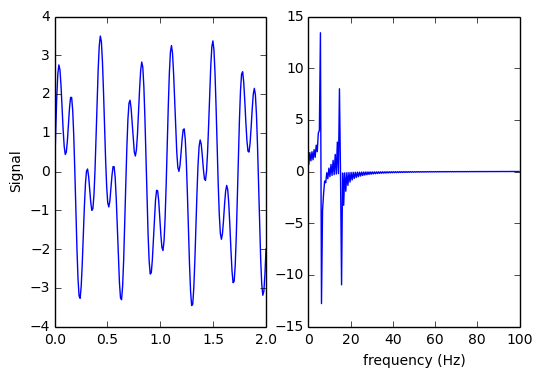

In [3]:
plt.subplot(121)
plt.plot(t,x)
plt.ylabel("Signal")

plt.subplot(122)
plt.plot(f,X)
plt.xlabel("frequency (Hz)")

In [4]:
# extract small sample of signal
m = int(n*0.15) # 5% sample
iS = np.sort(np.random.choice(n, m, replace=False)) # random sample of indices

tS = t[iS]
y  = x[iS]

(0, 2.0)

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


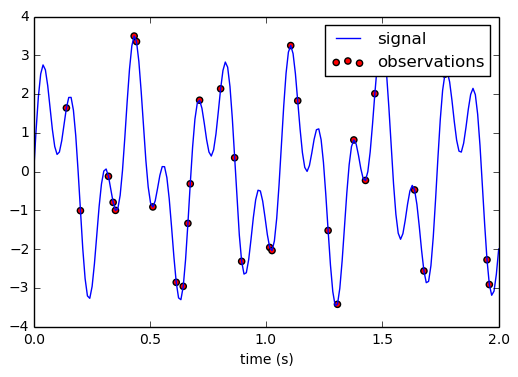

In [5]:
plt.plot(t,x,label="signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.xlabel("time (s)")
plt.legend()
plt.xlim([0,tMax])

### Interpolation


Scipy posseses an [interpolation module](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) that enables direct interpolation using splines.

In [6]:
import scipy.interpolate as spinter

tInt =  np.clip(t, min(tS), max(tS)) # We can only interpolate between the sampled values

intL = spinter.interp1d(tS, y , kind = "linear")
xL = intL(tInt)
intC = spinter.interp1d(tS, y , kind = "cubic")
xC = intC(tInt)

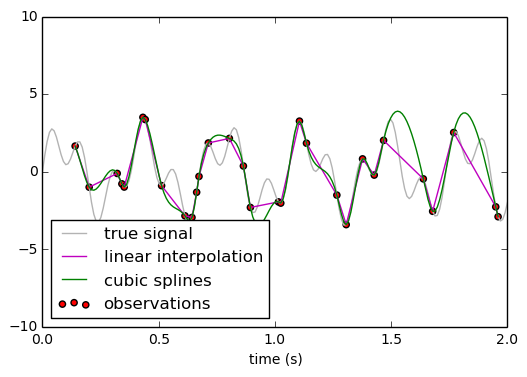

In [7]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(tInt,xL ,c='m',label="linear interpolation")
plt.plot(tInt,xC ,c='g',label="cubic splines")
plt.xlabel("time (s)")
plt.xlim([0,tMax])
plt.ylim([-10,10])
plt.legend(loc="lower left")

We see that interpolation is bad as we have *very few* points from a *complicated* signal in the temporal space. In Compressed sensing, we are going to use the signal *simplicity* in the cosine domain. 

### Compressed Sensing


The inverse discrete cosine tranform (IDCT) matrix $T$ will be obtained from <tt>scipy.fftpack</tt> (from the frequencial coefficients $Y$,  the matrix $T$, s.t. $T_{i,j} \propto \cos(2\pi f_j t_i)$, enables to retreive the temporal signal $y = TY$).

In [8]:
# create idct matrix operator
T = spfft.idct(np.identity(n), norm='ortho', axis=0)
T = T[iS]

We now want to recover an estimate $\hat{Y}$ of the DCT $X$ of $x$ by minimizing $\|y - TY\|$ over $Y$ under the contraint that $Y$ should be somehow sparse. 

To address this problem, two popular solutions are: 
* the **Dantzig Selector**, introduced in *Emmanuel Candes and Terrence Tao "The Dantzig selector: Statistical estimation when $p$ is much larger than $n$". The Annals of Statistics, 2007* can be used to compute $\hat{Y}$ in the case of an overparametrized problem, i.e. when the dimension $n$ of $\hat{Y}$ is well greater than the dimension $m$ of the observation $y$. <br/> In that case, the estimator $\widehat{Y}_{DS}$ is the solution of the optimization problem 
$$
\widehat{Y}_{DS} \in \arg\min_{Y\in \mathbb{R}^n} \left\{\|Y\|_1,\;\mbox{with}\;\|T^T(TY-y)\|_\infty\leq \kappa\sigma\right\},
$$
where $\sigma>0$ is an *hyper-parameter*. 

* the **Least Absolute Shrinkage and Selection Operator** or **lasso**, introduced in *Robert Tibshirani "Regression shrinkage and selection via the lasso", Journal of the Royal Statistical Society, 1996* can also be used to estimate $Y$. <br/> The estimator $\widehat{Y}_{L}$ is the solution of the optimization problem 
$$
\widehat{\theta}_{L} \in \arg\min_{\theta\in \mathbb{R}^n} \left\{ \|X\theta - y\|_2^2 + \kappa \sigma \|\theta\|_1 \right\},
$$
where $\sigma>0$ is an *hyper-parameter*. 

<div id="warn">
<b>Warning:</b> Below is the code for both estimators using <tt>cvxopt</tt> for solving linear or quadratic reformulated problems. <b><i>you are strongly encouraged to take a deeper look at these functions.</i></b>
</div>

In [9]:
from cvxopt import matrix, solvers
from scipy.stats import norm
import numpy as np

def DantzigSelector(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    # Computing kappa
    alpha = 0.05
    nu = max(np.linalg.norm(X, axis=0))
    kappa = nu*norm.ppf(1-alpha/(2.0*n)) 

    # Computing LP
    
    c = matrix(np.concatenate((np.zeros(n),np.ones(n))))
    
    G1 = np.hstack((np.eye(n),-np.eye(n)))
    G2 = np.hstack((-np.eye(n),-np.eye(n)))
    G3 = np.hstack((np.dot(X.T,X),np.zeros((n,n))))
    G4 = np.hstack((-np.dot(X.T,X),np.zeros((n,n))))
    
    G = matrix(np.vstack((G1,G2,G3,G4)))
    
    h = matrix(np.concatenate( ( np.zeros(n) , np.zeros(n) , kappa*sigma*np.ones(n) + np.dot(X.T,y) , kappa*sigma*np.ones(n) - np.dot(X.T,y) )  ))

    # Solving LP
    sol=solvers.lp(c,G,h) 
    theta = sol['x'][0:n]
    
    return  np.array(theta)

In [10]:
sigmaDS = 1e-1

YDS = DantzigSelector(y,T,sigmaDS)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -6.5512e+01  3e+03  4e+00  2e+00  1e+00
 1:  7.6743e+01  2.8310e+01  2e+03  3e+00  2e+00  3e+00
 2:  5.2565e+01  1.7305e+01  1e+03  3e+00  1e+00  5e+00
 3:  4.7759e+01  3.5556e+01  3e+02  1e+00  5e-01  3e+00
 4:  4.8437e+01  4.4063e+01  1e+02  4e-01  2e-01  2e+00
 5:  5.1677e+01  4.9694e+01  3e+01  1e-01  7e-02  3e-01
 6:  5.3243e+01  5.1927e+01  2e+01  9e-02  4e-02  2e-01
 7:  5.4462e+01  5.3829e+01  8e+00  4e-02  2e-02  2e-02
 8:  5.5500e+01  5.5285e+01  3e+00  1e-02  7e-03  5e-03
 9:  5.5875e+01  5.5808e+01  9e-01  4e-03  2e-03  1e-03
10:  5.5967e+01  5.5930e+01  5e-01  2e-03  1e-03  7e-04
11:  5.6019e+01  5.6001e+01  2e-01  1e-03  6e-04  4e-04
12:  5.6061e+01  5.6057e+01  6e-02  3e-04  1e-04  7e-05
13:  5.6076e+01  5.6076e+01  1e-03  5e-06  3e-06  1e-06
14:  5.6077e+01  5.6077e+01  1e-05  5e-08  3e-08  1e-08
Optimal solution found.


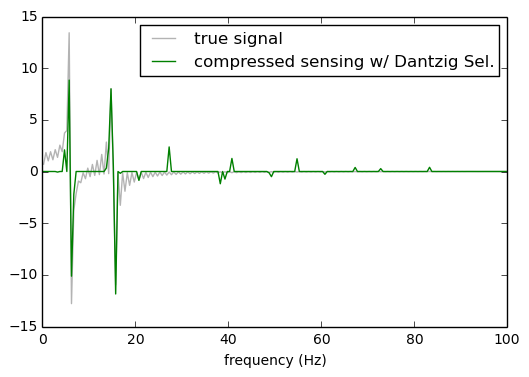

In [11]:
plt.plot(f,X ,c='0.7',label="true signal")
plt.plot(f,YDS ,c='g',label="compressed sensing w/ Dantzig Sel.")
plt.xlabel("frequency (Hz)")
#plt.xlim([0,100])
plt.legend()

From the *reconstructed frequential signal* $\hat{Y}$, we can retreive the full signal by inverse DCT.

In [12]:
xDS = spfft.idct(YDS, norm='ortho', axis=0)

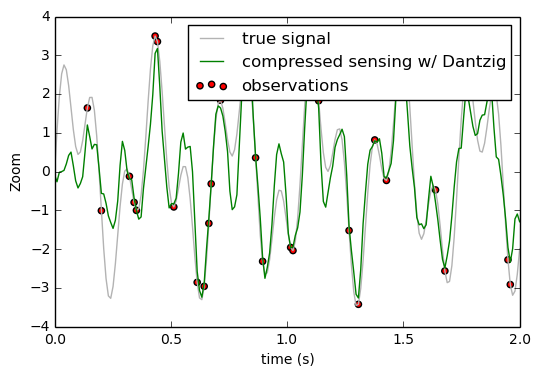

In [13]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(t,xDS ,c='g',label="compressed sensing w/ Dantzig")
plt.xlabel("time (s)")
plt.ylabel("Zoom")
plt.xlim([0,tMax])
plt.legend()

<div class="exo">
**Exercise 1-3.1:** Lasso 
<br/><br/>

We can try the same thing for the lasso. Implement a Lasso function in the model of the Dantzig Selector.

The reader is invited to play with the hyperparameter $\sigma$.

</div>



In [14]:
def Lasso(y,X,sigma):
    
    # Extracting the sizes
    m,n = X.shape
    
    return np.zeros((n,1)) #....................

In [15]:
sigma = 0.1

YLa = Lasso(y,T,sigma)

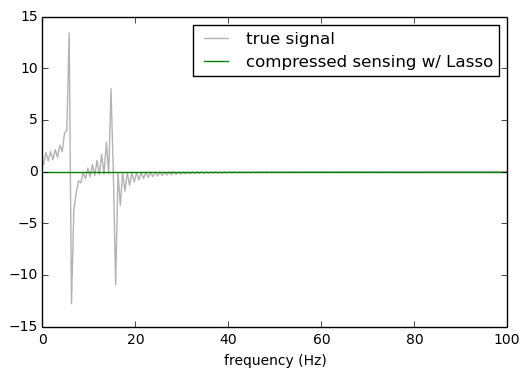

In [16]:
plt.plot(f,X ,c='0.7',label="true signal")
plt.plot(f,YLa ,c='g',label="compressed sensing w/ Lasso")
plt.xlabel("frequency (Hz)")
#plt.xlim([0,100])
plt.legend()

In [17]:
xLa = spfft.idct(YLa, norm='ortho', axis=0)

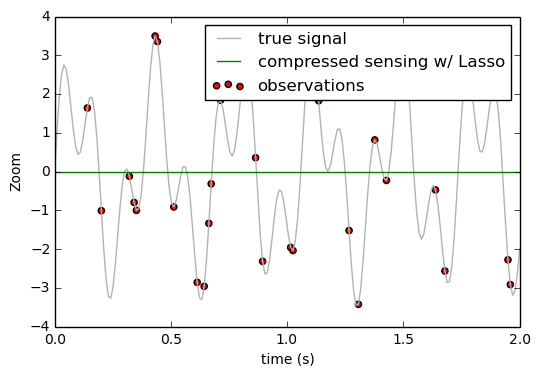

In [18]:
plt.plot(t,x ,c='0.7',label="true signal")
plt.scatter(tS,y , c = 'red', marker = 'o',label="observations")
plt.plot(t,xLa ,c='g',label="compressed sensing w/ Lasso" )
plt.xlabel("time (s)")
plt.ylabel("Zoom")
plt.xlim([0,tMax])
plt.legend()

---

## <a id="supCla"> b) Binary Classification</a>  


<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>



(array([[  6.37734541, -10.61510727],
       [  6.50072722,  -3.82403586],
       [  4.29225906,  -8.99220442],
       [  7.39169472,  -3.1266933 ],
       [  7.64306311, -10.02356892]]), array([1, 0, 1, 0, 1]))


/usr/lib/python2.7/dist-packages/scipy/sparse/coo.py:182: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) != 2:
/usr/lib/python2.7/dist-packages/scipy/sparse/coo.py:200: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(self.data) != 1 or np.rank(self.row) != 1 or np.rank(self.col) != 1:
/usr/lib/python2.7/dist-packages/scipy/sparse/sputils.py:141: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  if np.rank(M) == 0 and np.rank(N) == 0:
/usr/lib/python2.7/dist-packages/scipy/sparse/compressed.py:130: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.m

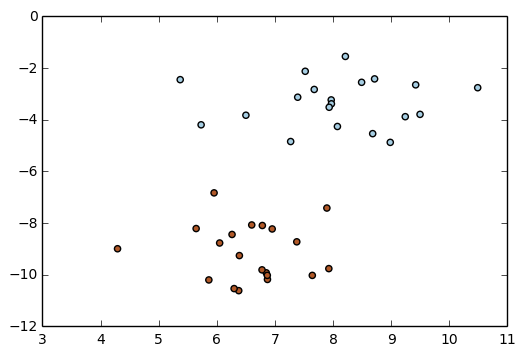

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:12.566172. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
%matplotlib inline

# we create 40 separable points in R^2 around 2 centers (random_state=6 is a seed so that the set is separable)
X, y = make_blobs(n_samples=40, n_features=2, centers=2 , random_state=6)

print(X[:5,:],y[:5]) # print the first 5 points and labels

plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.Paired)

Support Vector Machines (SVM) are based on learning a vector $w$ and an intercept $b$ such that the hyperplane $w^T x - b = 0$ separates the data i.e.  $a$ belongs to one class if  $w^T a - b > 0$ and the other elsewhere. 


They were later extended to *Kernel methods* that is  $\kappa(w, a) - b = 0$ is now the separating *curve* where $\kappa$ is the *kernel*, typically:
* linear: $\kappa(x,y)= x^T y$ (original SVM) 
* polynomial: $\kappa(x,y)= (x^T y)^d$ 
* Gaussian radial basis function (rfb):   $\kappa(x,y)= \exp( - \gamma \| x - y \|^2 )$

In [20]:
from sklearn.svm import SVC # Support vector classifier i.e. Classifier by SVM

modelSVMLinear = SVC(kernel="linear")
modelSVMLinear.fit(X,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:12.850949. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


The following illustration can be found in the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas.

In [21]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:12.884838. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/usr/lib/pymodules/python2.7/matplotlib/contour.py:1497: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  self.zmax = ma.maximum(z)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1498: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  self.zmin = ma.minimum(z)
/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1446: Depre

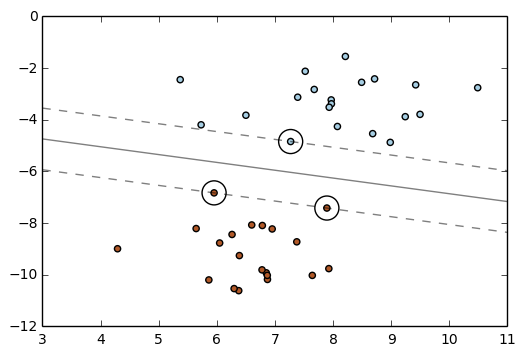

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:12.902172. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [22]:
plt.scatter(X[:, 0], X[:, 1], c=y ,  cmap=plt.cm.Paired)
plot_svc_decision_function(modelSVMLinear)

We see clearly that the linear SVM seeks at maximizing the *margin* between the hyperplane and the two well defined classes from the data.

### Non-separable data

In real cases, the data is usually not linearly separable as before.

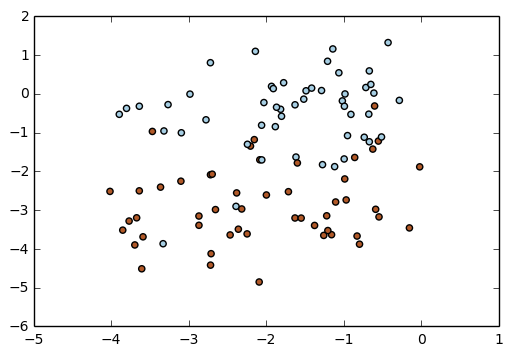

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.111920. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [23]:
# we create points in R^2 around 2 centers (random_state=48443 is a seed so that the set is *not* separable)
X, y = make_blobs(n_samples=100, n_features=2, centers=2 , random_state=48443)

plt.scatter(X[:, 0], X[:, 1], c=y,  cmap=plt.cm.Paired)

Let us use the *same* linear SVM classifier. Obviously, there are *misclassified points*, the model is thus learnt not by maximizing the margin (which does not exist anymore) but by minimizing a penalty over misclassified data. This penalty takes the form of an allowance margin controlled by a parameter $C$. The smaller $C$ the more inclusive the margin. Finding a good value for $C$ is up to the data scientist.

In [24]:
try:
    from sklearn.model_selection import train_test_split    # sklearn > ...
except:
    from sklearn.cross_validation import train_test_split   # sklearn < ...
    
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.5) # split data in two

model1 = SVC(kernel="linear",C=0.01)
model1.fit(XTrain,yTrain)

model2 = SVC(kernel="linear",C=100)
model2.fit(XTrain,yTrain)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.297922. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


/usr/lib/pymodules/python2.7/matplotlib/contour.py:1497: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  self.zmax = ma.maximum(z)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1498: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  self.zmin = ma.minimum(z)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1446: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1447: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1448: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1449: Depr

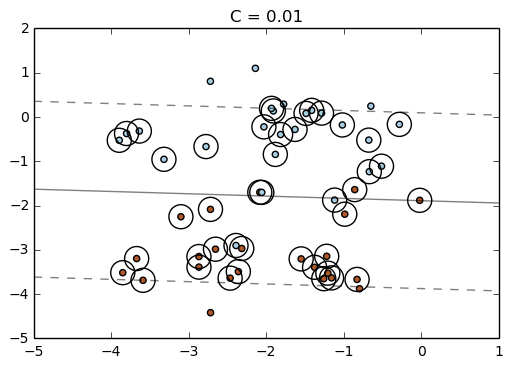

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.311437. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [25]:
plt.scatter(XTrain[:, 0], XTrain[:, 1], c=yTrain ,  cmap=plt.cm.Paired)
plot_svc_decision_function(model1)
plt.title("C = 0.01")

/usr/lib/pymodules/python2.7/matplotlib/contour.py:1497: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  self.zmax = ma.maximum(z)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1498: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  self.zmin = ma.minimum(z)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1446: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  x0 = ma.minimum(x)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1447: DeprecationWarning: Single-argument form of np.ma.maximum is deprecated. Use np.ma.maximum.reduce instead.
  x1 = ma.maximum(x)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1448: DeprecationWarning: Single-argument form of np.ma.minimum is deprecated. Use np.ma.minimum.reduce instead.
  y0 = ma.minimum(y)
/usr/lib/pymodules/python2.7/matplotlib/contour.py:1449: Depr

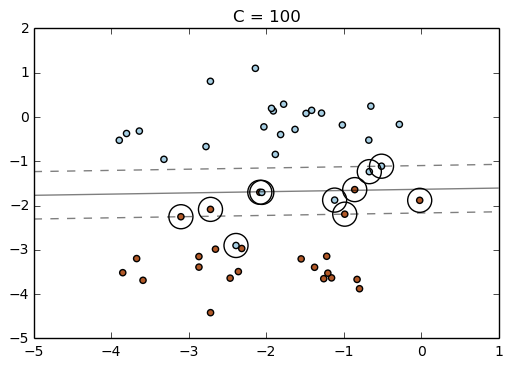

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.522320. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [26]:
plt.scatter(XTrain[:, 0], XTrain[:, 1], c=yTrain ,  cmap=plt.cm.Paired)
plot_svc_decision_function(model2)
plt.title("C = 100")

To find out which value of $C$ to use or globally the performance of the classifier, one can use Scikit Learn's [classification metrics](http://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics), for instance the confusion matrix.

In [27]:
from sklearn.metrics import confusion_matrix


yFit1 = model1.predict(XTest)
yFit2 = model2.predict(XTest)


mat1 = confusion_matrix(yTest, yFit1)
mat2 = confusion_matrix(yTest, yFit2)

print('Model with C = 0.01')
print(mat1)
print("Model with C = 100")
print(mat2)

Model with C = 0.01
[[22  2]
 [ 7 19]]
Model with C = 100
[[21  3]
 [ 6 20]]


/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.712758. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


It can also be plotted in a fancier way with seaborn.

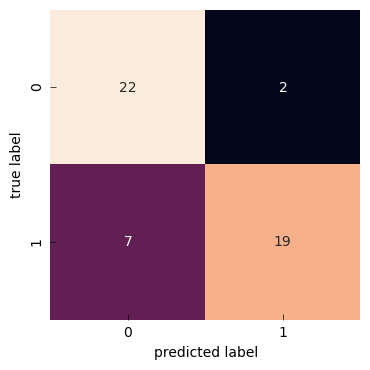

/usr/lib/python2.7/json/encoder.py:207: DeprecationWarning: Interpreting naive datetime as local 2018-09-12 14:42:13.726188. Please add timezone info to timestamps.
  chunks = self.iterencode(o, _one_shot=True)


In [28]:
import seaborn as sns

sns.heatmap(mat1, square=True, annot=True ,cbar=False)
plt.ylabel('true label')
plt.xlabel('predicted label')

<div class="exo"> <b>Exercise 1-3.2:</b> 
a very popular binary classification exercise is the <a href="https://www.kaggle.com/c/titanic">survival prediction from Titanic shipwreck on Kaggle</a>. <br/><br/>

<i> The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.<br/>

    One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.<br/>

    In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.<br/><br/><br/></i>
    
    
The data - taken from <a href="https://www.kaggle.com/c/titanic">Kaggle</a> - is located in <tt>data/titanic/train.csv</tt> and has the following form:

<table>
<tbody>
<tr><th><b>Feature</b></th><th><b>Definition</b></th><th><b>Comment</b></th></tr>
<tr>
<td>PassengerId</td>
<td>ID</td>
<td>numeric</td>
</tr>
<tr>
<td>Survival</td>
<td>Survival of the passenger</td>
<td>0 = No, 1 = Yes <b>target to predict</b></td>
</tr>
<tr>
<td>Pclass</td>
<td>Ticket class</td>
<td>1 = 1st, 2 = 2nd, 3 = 3rd</td>
</tr>
<tr>
<td>Name</td>
<td>Full name w/ Mr. Mrs. etc.</td>
<td>string</td>
</tr>
<tr>
<td>Sex</td>
<td>Sex</td>
<td><tt>male</tt> or <tt>female</tt></td>
</tr>
<tr>
<td>Age</td>
<td>Age in years</td>
<td>numeric</td>
</tr>
<tr>
<td>SibSp</td>
<td># of siblings / spouses aboard the Titanic</td>
<td>numeric</td>
</tr>
<tr>
<td>Parch</td>
<td># of parents / children aboard the Titanic</td>
<td></td>
</tr>
<tr>
<td>Ticket</td>
<td>Ticket number</td>
<td>quite messy</td>
</tr>
<tr>
<td>Fare</td>
<td>Passenger fare</td>
<td></td>
</tr>
<tr>
<td>cabin</td>
<td>Cabin number</td>
<td>letter + number (e.g. C85), often missing</td>
</tr>
<tr>
<td>Embarked</td>
<td>Port of Embarkation</td>
<td>C = Cherbourg, Q = Queenstown, S = Southampton</td>
</tr>
</tbody>
</table>

<ul>
<li> Load the dataset and preprocess the features. (you can remove features that seem uninteresting to you).
<li> Perform binary classification to predict the survival of a passenger depending on its information and validate you approach.
<li> Perform some feature engineering to improve the performance of you classifier (see e.g. <a href="https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/">here</a>)
</ul>
</div>

---
<div id="style"></div>
### Package Check and Styling


<p style="text-align: right; font-size: 10px;"><a href="#top">Go to top</a></p>


In [ ]:
import lib.notebook_setting as nbs

packageList = ['IPython', 'numpy', 'scipy', 'matplotlib', 'cvxopt']
nbs.packageCheck(packageList)

nbs.cssStyling()